# vLife Virtusa
## Drug Forecasting Excellence
### Usecase Description
_As a provider, To know about the consumption of medications in forecasting year, we have used SARIMAX model to predict the future comsumption population of T2D related medications. To built model, Synthetic Data of T2D patients were used._

### Dataset Source
Data for this usecase is extracted from Data as Service on vLife Platform.

### Dataset Description
#### Feature Description
* Subject - patient ID
* year - admit year
* t2d_year-T2D onset year
* genric_name - Medications

**Import Section**

In [1]:
import time
import pandas as pd
import numpy as np
import psycopg2
from plotly import *
from random import random
import plotly.graph_objs as go
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from pylab import *

from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
%%time
data4 = pd.read_csv("data_FE.csv")

CPU times: user 100 ms, sys: 17.6 ms, total: 118 ms
Wall time: 161 ms


In [3]:
data4.head()

,subject,years,t2d_year,generic_name
0,348bb7d9-9c5b-4833-802b-64b8bbe79efb,1977,2012,NORETHINDRONE-MESTRANOL
1,a6af62d1-e4fb-4efa-930c-752c010c1523,1956,2001,PEN G POT/DEXTROSE-WATER
2,a6af62d1-e4fb-4efa-930c-752c010c1523,1957,2002,ASPIRIN/CALCIUM CARBONATE/MAG
3,a6af62d1-e4fb-4efa-930c-752c010c1523,2001,2002,FLUTICASONE/SALMETEROL
4,a6af62d1-e4fb-4efa-930c-752c010c1523,1975,2007,IRBESARTAN/HYDROCHLOROTHIAZIDE


In [4]:
data4.shape

(165729, 4)

## Exploratory Data Analysis
### Data Preprocessing for Time Series Data

In [5]:
%%time
d = pd.DataFrame()
for i in data4['years'].unique().tolist():
    temp= data4[(data4['subject'].isin(data4[data4.years==i].subject.unique().tolist()))&(data4['years']==i)].groupby(['years','generic_name']).agg({'subject':'count'}).reset_index()
    d=pd.concat([d,temp],axis=0).reset_index(drop=True)

CPU times: user 1.93 s, sys: 1.46 ms, total: 1.93 s
Wall time: 1.92 s


In [6]:
d.head()

,years,generic_name,subject
0,1977,"""INSULIN GLARGINE,HUM.REC.ANLOG""",2
1,1977,ACETAMINOPHEN,268
2,1977,AMPICILLIN SODIUM,66
3,1977,ASPIRIN/CALCIUM CARBONATE/MAG,44
4,1977,DIAZEPAM,20


In [7]:
d.to_csv("forecastexcellence.csv",index=False)

## Predictive Models
#### Time Series Forecasting SARIMAX

In [9]:
len(d.generic_name.unique())

82

In [10]:
temp =['ESTRADIOL VALERATE/DIENOGEST','LEVONORGESTREL-ETHIN ESTRADIOL','MILNACIPRAN HCL','DULOXETINE HCL',
'METHOTREXATE SODIUM','ISOFLURANE','PROPOFOL','ROCURONIUM BROMIDE','ONDANSETRON HCL/PF','MORPHINE SULFATE',
'ALFENTANIL HCL','MEMANTINE HCL','SODIUM CHLORIDE','"HEPARIN SODIUM,PORCINE"','METOPROLOL SUCCINATE',
'ETOPOSIDE PHOSPHATE','"CYCLOSPORINE, MODIFIED"','CETIRIZINE HCL','SEVOFLURANE','DORNASE ALFA']

In [11]:
for i in temp:
    data4 = data4[data4['generic_name']!=i]

In [12]:
df = pd.DataFrame()
k = 0
for i in data4.generic_name.unique().tolist():
    data5 = d[(d['generic_name'] == i) & (d['years'] < 2019)][['subject', 'years']].sort_values(by='years')
    # fit model
    model = SARIMAX(data5.subject, exog=data5.years, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0),
                    enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    # make prediction
    exog2 = [[x] for x in range(2019, 2029)]
    yhat = model_fit.predict(len(data5.subject), len(data5.subject) + 9, exog=exog2)
    exog2 = [x for x in range(2019, 2029)]
    temp1 = data5[(data5['years'] > 2000) & (data5['years'] < 2019)].reset_index(drop=True)
    temp = pd.DataFrame(columns=['years', 'subject'])
    temp['years'] = exog2
    temp['subject'] = yhat.tolist()
    temp['subject'] = temp['subject'].astype(int)
    temp = pd.concat([temp1, temp], axis=0)
    temp.reset_index(drop=True)
    temp[i] = temp['subject']
    del temp['subject']
    temp.reset_index(inplace=True, drop=True)
    if k != 0:
        temp = temp[[i]]
    k = k + 1
    df = pd.concat([df, temp], axis=1)

df = df.head(12)
print("Shape of DataFrame:",df.shape)
drop_cols =[]
for col in df.columns.to_list():
    if ~((df[col] >= 0).all()):
        drop_cols.append(col)
print("Drop cols list and size: ",drop_cols,len(drop_cols))
df = df.drop(drop_cols, axis=1)
df = df.fillna(0)
print("Shape of DataFrame:",df.shape)
li = list(df.columns)
for i in range(0,len(li)):
    li[i] = li[i].replace('/', '-').replace(',', ' and ').replace('"', '')
df.columns = li

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning:

An unsupported index was provided and will be ignored w

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning:

An unsupported index w

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning:

An unsupported index w

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning:

An unsupported index w

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning:

An unsupported index w

Shape of DataFrame: (12, 63)
Drop cols list and size:  ['PEN G POT/DEXTROSE-WATER', 'ASPIRIN/CALCIUM CARBONATE/MAG', 'AMPICILLIN SODIUM', 'NORETH A-ET ESTRA/FE FUMARATE', 'ALBUTEROL', 'CEFUROXIME AXETIL', 'CEFACLOR', 'OLANZAPINE/FLUOXETINE HCL', 'LEVOTHYROXINE SODIUM', 'METHYLPHENIDATE HCL', 'CHLORPHENIRAMINE MALEATE', 'CARBAMAZEPINE'] 12
Shape of DataFrame: (12, 51)


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [13]:
df.head()

,years,NORETHINDRONE-MESTRANOL,FLUTICASONE-SALMETEROL,IRBESARTAN-HYDROCHLOROTHIAZIDE,NORGESTIMATE-ETHINYL ESTRADIOL,ACETAMINOPHEN,GLIMEPIRIDE,SIMVASTATIN,METFORMIN HCL,GLYBURIDE,...,AMIODARONE HCL,EPINEPHRINE,DOCETAXEL,PACLITAXEL PROTEIN-BOUND,ATORVASTATIN CALCIUM,NITROFURANTOIN MACROCRYSTAL,MEDROXYPROGESTERONE ACETATE,ATROPINE SULFATE,SERTRALINE HCL,CAPTOPRIL
0,2001.0,294.0,6.0,147,203.0,534,60.0,697,118,58,...,22.0,31.0,2.0,9.0,2.0,6.0,20.0,22.0,1.0,2.0
1,2002.0,16.0,6.0,113,4.0,613,6.0,695,81,74,...,2.0,2.0,6.0,12.0,33.0,28.0,4.0,2.0,9.0,33.0
2,2019.0,107.0,9.0,136,22.0,427,77.0,758,243,21,...,2.0,2.0,71.0,12.0,8.0,10.0,91.0,2.0,8.0,8.0
3,2020.0,97.0,17.0,102,22.0,472,49.0,691,106,26,...,13.0,4.0,56.0,6.0,11.0,6.0,16.0,13.0,6.0,11.0
4,2021.0,91.0,24.0,71,21.0,340,40.0,691,152,38,...,12.0,25.0,6.0,8.0,12.0,19.0,22.0,12.0,6.0,12.0


> **Dropdown list to select a feature to Simulate**

In [14]:
import ipywidgets as widgets
from IPython.display import display
columns = df.columns.tolist()[1:]
style = {'description_width': 'initial'}
w = widgets.Dropdown(
    options=columns,
    description='Select a Year:',style=style,disabled=False
)
display(w)

Dropdown(description='Select a Year:', options=('NORETHINDRONE-MESTRANOL', 'FLUTICASONE-SALMETEROL', 'IRBESART…

> **Line Plot to Show Predictions**

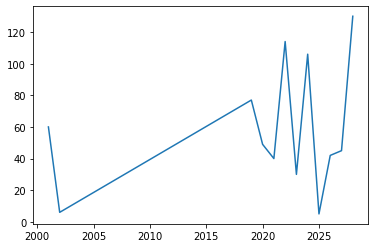

In [15]:
user_input = w.value
df1 = pd.DataFrame({'x':df['years'],'y':df[user_input]})
plt.plot('x','y',data=df1)
plt.savefig('viz.png')
savefig('viz.png', bbox_inches='tight')

## END